<a href="https://colab.research.google.com/github/jindaldisha/Deep-Learning-and-Neural-Networks/blob/main/02_3_multiclass_neural_network_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multi-class Neural Network with PyTorch

We'll solve an image classification problem. The dataset used is the `MNIST Handwritten Digits Database`. It consists of `28px by 28px` grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents. We will use a feed forward neural netowrk to do that. This model will be able to capture the non-linear relation between the inputs and targets.

In [ ]:
#Import Libraries
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

##Import Data

The dataset consists of tuple consisting of a 28x28 image and its label. Originally the image are an object of class `PIL.Image.Image`, which is a part of the Python imaging library Pillow. We need to convert the images into tensors as PyTorch doesn't work with images. We can do this by specifying a transform while creating our dataset.


In [ ]:
#Download training and test dataset (it is going to download inside 'data' directory and creates a PyTorch Dataset)
dataset = MNIST(root='data/', 
                download = True, 
                train = True, 
                transform = transforms.ToTensor())
test_dataset = MNIST(root='data/', 
                     train=False, 
                     transform = transforms.ToTensor())

In [ ]:
#Check size of the dataset
len(dataset), len(test_dataset)

(60000, 10000)

The training dataset has 60,000 images that we'll use to train and evaluate our model. And the testing dataset has 10,000 images that we'll use for testing purposes.

In [ ]:
#Look at a sample dataset element
image, label = dataset[0]
image.shape, label

(torch.Size([1, 28, 28]), 5)

The images have been converted to a 1x28x28 tensors. The first dimension tracks the color channels. The second and third dimension represents pixels along the height and width of the image respectively. Since the dataset we're using has only grayscale image, there is only one color channel.

In [ ]:
#Range of pixel values
print('Max Value of Pixel: ', torch.max(image).item())
print('Min Value of Pixel: ', torch.min(image).item())

Max Value of Pixel:  1.0
Min Value of Pixel:  0.0


The pixel values range from 0 to 1, representing black and white respectively. And the value in between different shades of grey.

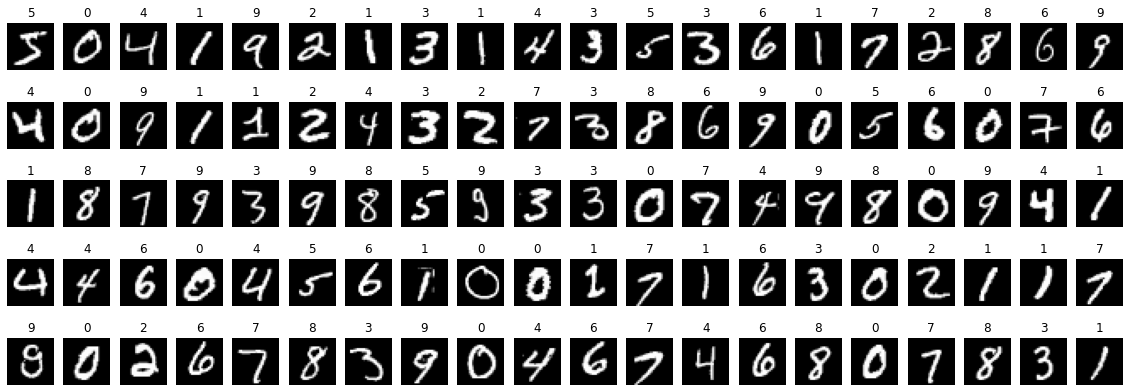

In [ ]:
#Plot multiple sample images
plt.figure(figsize=(20,7))
# plt.subplots_adjust(hspace=0.4, wspace=0.5)
for i in range(100):
  plt.subplot(5,20,i+1)
  image, label = dataset[i]
  #We pass only the 28x28 matrix and exclude the color channel
  plt.imshow(image[0], cmap='gray')
  plt.title(label)
  plt.axis(False)

#Training and Validation Datasets


While building real-world machine learning models, it is quite common to split the dataset into three parts:

1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.
2. **Validation set** - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.
3. **Test set** - used to compare different models or approaches and report the model's final accuracy.

In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is standardized so that different researchers can report their models' results against the same collection of images. 

Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for validation. We can do this using the `random_spilt` method from PyTorch.

It is essential to choose a random sample for creating a validation set. Training data is often sorted by target labels. If we create a validation set using consecutive images, it would consist of similar images. Such training and validation datasets would make it impossible to train a useful model.

In [ ]:
#Spliting dataset into training and validation sets
validation_size = 1000
train_size = len(dataset) - validation_size

train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])
len(train_dataset), len(validation_dataset)

(59000, 1000)

When working with large datasets, its not possible to train the entire dataset at once as it may not fit into the memory and even if it does, the entire process will be very slow. And therefore what we do instead is take the dataset and break it into batches and train our model batch by batch.

We'll also create a `DataLoader`, which can split the data into batches of a predefined size while training. It also provides other utilities like shuffling and random sampling of the data.

We can set the `shuffle = True` in `DataLoader`. This helps randomize the input to optimization algorithm, leading to a faster reduction in loss. This also helps in generalization i.e. it helps in improving the performace of the model on data it has never seen before.

In [ ]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size, num_workers=2, pin_memory=True) #validation_dataset is already shuffled

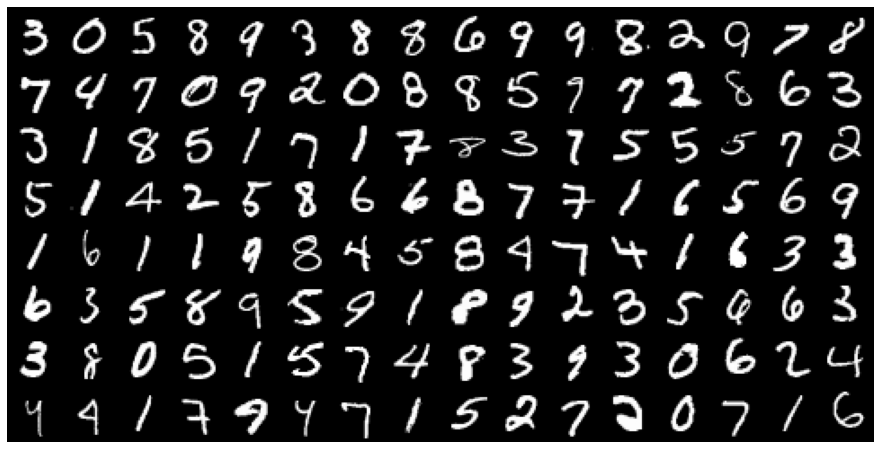

In [ ]:
#Visualize a batch of images
for images, labels in train_loader:
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute((1,2,0)));
  break

#Hidden Layers, Activation Functions and Non-Linearity

We'll create a neural network with two layers: a hidden layer and an output layer. There will also be an activation function between the two layers.

Firstly, we'll flatten the `1x28x28` images into vectors of size `28*28 = 784`, so that they can be passed into an nn.Linear layer.

In [ ]:
#input size
input_size = 28*28
#hidden units
hidden_size = 32
#output size
output_size = 10

In [ ]:
for image, labels in train_loader:
   inputs = image.reshape(-1,input_size)
   break

The `nn.Linear` layer will server as our hidden layer. We can calculate intermediate outputs for the batch of images by passing input through it.


In [ ]:
layer1 = nn.Linear(input_size, hidden_size)

In [ ]:
#Intermediate outputs through layer1
layer1_outputs = layer1(inputs)

In [ ]:
print('Input Shape: ', inputs.shape)
print('Layer1 Weights Transform Shape:', layer1.weight.t().shape)
print('Layer1 Biases Shape: ', layer1.bias.shape)
print('Layer1 Output Shape: ', layer1_outputs.shape)

Input Shape:  torch.Size([128, 784])
Layer1 Weights Transform Shape: torch.Size([784, 32])
Layer1 Biases Shape:  torch.Size([32])
Layer1 Output Shape:  torch.Size([128, 32])


Since we use the formula `y = x @ w.t() + b`, and the hidden output size is `32`, we get an output shape of `(128,32)`. The image vectors of size `784` are transformed into intermediate output vectors of length `32` by performing a matrix multiplication of inputs matrix with the transposed weights matrix of layer1 and adding the bias.

Also the `layer1_outputs` and `inputs` have a linear relation. Each element in `layer_outputs` is a weighted sum of elements from `inputs`. Thus, even as we train the model and modify the weights, `layer1` can only capture linear relation between `inputs` and `outputs`.


We'll use the Rectified Linear Unit (ReLU) function as an activation function for the outputs to add non-linearity to our model. It has the formula `relu(x) = max(0, x)`. We replace the negative values in a given tensor with `0`.

In [ ]:
#Apply relu activation function to layer1_outputs
relu_outputs = F.relu(layer1_outputs)

After appling `ReLU` activation function to our inputs, our new outputs `relu_outputs` and `inputs` no longer have a linear relation. `ReLU` is called an activation function because for each input, certain outputs are activated (non-zero values) and others are turned off (zero values).


Next step is create an output layer that will convert the current vector output `relu_outputs` of length `hidden_size` into vectors of length 10, since that is the number of target labels that we have.

In [ ]:
#Define output layer
layer2 = nn.Linear(hidden_size, output_size)

In [ ]:
layer2_outputs = layer2(relu_outputs)
print('Layer2 Outputs Shape: ', layer2_outputs.shape)

Layer2 Outputs Shape:  torch.Size([128, 10])


Now we can use outputs from the output layer and calculate loss and then use gradient descent to adjust the weights of layer1 and layer2.

In [ ]:
#Loss function
loss = F.cross_entropy(layer2_outputs, labels)
print('Loss: ', loss.item())

Loss:  2.310033082962036


In summary, our model transforms `inputs` into `layer2_outputs` by first applying a linear transformation in `layer 1` followed by the non linear activation function `relu` and then followed by another linear transformation in `layer 2`. Since the outputs and inputs do not have a linear relation because of the non-linear activation function, as we train the model, we can now capture the non-linear relationship between the images and their labels. 

#Model

We'll create a neural network with one hidden layer.

* We'll use two `nn.Linear` objects. Each of these is called a _layer_ in the network. 

* The first layer (also known as the hidden layer) will transform the input matrix of shape `batch_size x input_size` into an intermediate output matrix of shape `batch_size x hidden_size`. The parameter `hidden_size` can be configured manually (e.g., 32 or 64).

* We'll then apply a non-linear *activation function* to the intermediate outputs. The activation function transforms individual elements of the matrix.

* The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also known as the output layer).  The second layer transforms it into a matrix of size `batch_size x output_size`. We can use this output to compute the loss and adjust weights using gradient descent.

- In `__init__` constructor, we instantiate weights and biases using nn.Linear for hidden and output layer.
- Our images are of the shape 1x28x28, but we need them to be vectors of size 784, i.e., we need to flatten them. Inside `forward` method, we flatten the input image tensors and pass it to `self.layer1`.
- Then we pass the outputs from layer1 to the relu activation function.
- The outputs from the activation function are then passed on to the output layer.
- In `training_step` method, we first generate predictions and then using these predictions and true labels, we calculate the loss.
- In `validation_step` method, we first generate predictions and then using these predictions and true labels, we calculate loss and accuracy.
- In `validation_epoch_end` method, we take the mean of accuracy and loss for an epoch.
- In `epoch_end` method, we simply print the average accuracy and loss for an epoch that we calculated in `validation_epoch_end`.

In [ ]:
class Model(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    #Hidden Layer
    self.layer1 = nn.Linear(input_size, hidden_size)
    #Output Layer
    self.layer2 = nn.Linear(hidden_size, output_size)
  
  def forward(self, xb):
    #Flatten the image tensors
    xb = xb.view(xb.size(0), -1)
    #Hidden layer outputs
    output = self.layer1(xb)
    #Activation Function
    output = F.relu(output)
    #Output Layer
    output = self.layer2(output)
    return output
  
  def training_step(self, batch):
    images, labels = batch
    #generate predictions
    output = self(images)
    #calculate loss
    loss = F.cross_entropy(output, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    #generate predictions
    output = self(images)
    #calculate loss
    loss = F.cross_entropy(output, labels)
    #calculate accuracy
    acc = accuracy(output, labels)
    return {'val_loss': loss, 'val_acc': acc}
  
  def validation_epoch_end(self, outputs):
    batch_loss = [x['val_loss'] for x in outputs]
    #Mean Loss
    epoch_loss = torch.stack(batch_loss).mean()
    batch_acc = [x['val_acc'] for x in outputs]
    #Mean Accuracy
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
  
  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
#accuracy
def accuracy(outputs, labels):
  probs, preds = torch.max(outputs, dim=1)
  num_of_equals = torch.sum(preds == labels).item()
  num_of_elements = len(preds)
  acc = torch.tensor(num_of_equals/num_of_elements)
  return acc

In [ ]:
model = Model(input_size, hidden_size, output_size)

In [ ]:
#model parameters
for x in model.parameters():
  print(x.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [ ]:
#test our model on one batch
for images, labels in train_loader:
  outputs = model(images)
  loss = F.cross_entropy(outputs, labels)
  print('Loss: ', loss.item())
  break
print('Output Shape: ', outputs.shape)
print('Sample Output: ', outputs[0].data)

Loss:  2.2820003032684326
Output Shape:  torch.Size([128, 10])
Sample Output:  tensor([ 0.1870,  0.0325,  0.0342,  0.3582, -0.4005,  0.1733, -0.3101, -0.1136,
        -0.1146, -0.1279])


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


##Training the Model

So far we've created:
- Data loaders
- The model
- Loss Function

Now the next step is to train the model. We have a training phase and a validation phase for every epoch.

Steps (for every epoch):
- Training Phase (for every batch)
  - Load the batch
    - Generate predictions
    - Calculate loss
    - Compute gradients
    - Update weights
    - Reset gradients
- Validation Phase (for every batch)
  - Load the batch
    - Generate predictions
    - Calculate loss
    - Calculate metrics (accuracy, etc.)
- Calculate  average validation loss and metrics

- Log epoch, loss and metrics for inspection

The fit function records the validation loss and metric from each epoch. It returns a history of the training, useful for debugging & visualization.

Configurations like batch size, learning rate, etc. (called hyperparameters), need to picked in advance while training machine learning models. Choosing the right hyperparameters is critical for training a reasonably accurate model within a reasonable amount of time.

In [ ]:
#evalute function returns the average loss and everage accuracy for validation dataset.
def evaluate(model, validation_loader):
  outputs = [model.validation_step(batch) for batch in validation_loader]
  return model.validation_epoch_end(outputs)

In [ ]:
#function to fit the model to data
def fit(epochs, lr, model, train_loade, validation_loader, opt_func=torch.optim.SGD):
  #define optimizer
  optimizer = opt_func(model.parameters(), lr)
  history = [] #record result every epoch

  for epoch in range(epochs):
    #Training phase
    for batch in train_loader:
      #calculate loss
      loss = model.training_step(batch)
      #compute gradients
      loss.backward()
      #update gradients
      optimizer.step()
      #reset gradients to zero
      optimizer.zero_grad()
    
    #Validation phase
    result = evaluate(model, validation_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history


**Summary:**

- When we call the fit function to fit the model to the data, for each epoch, we are getting batches from training dataloader `train_loader` and validation data loader `validation_loader`. These batches contain a set of images and a set of labels. We pass them onto the model. 
- The model then evokes the `forward` function. Which first reshapes the images into the shape `(batch_size, input_size)`. Then this batch of reshaped images is passed into the the layers that we've defined in the `__init__` constructor. In this case we have one hidden layer and one output layer with an activation function between them.  
- Since we use the formula `y = x @ w.t() + b`, and the hidden output size is `32`, we get an output shape of `(128,32)`. The image vectors of size `784` are transformed into intermediate output vectors of length `32` by performing a matrix multiplication of inputs matrix with the transposed weights matrix of layer1 and adding the bias. Also the `layer1_outputs` and `inputs` have a linear relation. Each element in `layer_outputs` is a weighted sum of elements from `inputs`. Thus, even as we train the model and modify the weights, `layer1` can only capture linear relation between `inputs` and `outputs`. 
- We use the Rectified Linear Unit (ReLU) function as an activation function for the outputs to add non-linearity to our model. It has the formula `relu(x) = max(0, x)`. We replace the negative values in a given tensor with `0`. After appling `ReLU` activation function to our inputs, our new outputs and `inputs` no longer have a linear relation. 
- Next step is create an output layer that will convert the current vector output of length `hidden_size` into vectors of length 10, since that is the number of target labels that we have.
- We then take these predicted values and compare them with the true labels by first performing `softmax`, which basically converts the predicted values to probabilities. Then we use `cross-entropy`. It is the negative logarithm of the predicted probability of the correct label averaged over all training examples. It just means the predicted probability of the correct label is e^(-loss). The lower the loss, the higher thr probability of the correct label and the better the model.
- Then in order to reduce the loss, we perform `gradient descent`. And then update the weights and biases to improve the model. 
- Then we load the `validation_dataloader` and run it throught the model batch by batch to get the losses and accuracies. 
-We take the mean of all the losses and accuracies for each epoch to evaluate how our model is performing.

In [ ]:
#Create Model
model = Model(input_size, hidden_size, output_size)

In [ ]:
#Initial history
history = [evaluate(model, validation_loader)]
history

[{'val_acc': 0.1879507154226303, 'val_loss': 2.302633285522461}]

In [ ]:
#Fit the Model for 100 epochs
history += fit(100, 0.001, model, train_loader, validation_loader)


Epoch [0], val_loss: 2.2303, val_acc: 0.3331
Epoch [1], val_loss: 2.1307, val_acc: 0.3585
Epoch [2], val_loss: 2.0182, val_acc: 0.4447
Epoch [3], val_loss: 1.8979, val_acc: 0.5405
Epoch [4], val_loss: 1.7707, val_acc: 0.6251
Epoch [5], val_loss: 1.6386, val_acc: 0.6674
Epoch [6], val_loss: 1.5072, val_acc: 0.7093
Epoch [7], val_loss: 1.3812, val_acc: 0.7395
Epoch [8], val_loss: 1.2641, val_acc: 0.7646
Epoch [9], val_loss: 1.1591, val_acc: 0.7855
Epoch [10], val_loss: 1.0671, val_acc: 0.8024
Epoch [11], val_loss: 0.9885, val_acc: 0.8121
Epoch [12], val_loss: 0.9211, val_acc: 0.8209
Epoch [13], val_loss: 0.8635, val_acc: 0.8258
Epoch [14], val_loss: 0.8142, val_acc: 0.8336
Epoch [15], val_loss: 0.7718, val_acc: 0.8407
Epoch [16], val_loss: 0.7352, val_acc: 0.8438
Epoch [17], val_loss: 0.7029, val_acc: 0.8468
Epoch [18], val_loss: 0.6744, val_acc: 0.8499
Epoch [19], val_loss: 0.6492, val_acc: 0.8538
Epoch [20], val_loss: 0.6268, val_acc: 0.8601
Epoch [21], val_loss: 0.6069, val_acc: 0.861

In [ ]:
history += fit(50, 0.001, model, train_loader, validation_loader)

Epoch [0], val_loss: 0.3174, val_acc: 0.9101
Epoch [1], val_loss: 0.3166, val_acc: 0.9111
Epoch [2], val_loss: 0.3156, val_acc: 0.9111
Epoch [3], val_loss: 0.3148, val_acc: 0.9111
Epoch [4], val_loss: 0.3140, val_acc: 0.9111
Epoch [5], val_loss: 0.3132, val_acc: 0.9101
Epoch [6], val_loss: 0.3124, val_acc: 0.9111
Epoch [7], val_loss: 0.3116, val_acc: 0.9111
Epoch [8], val_loss: 0.3109, val_acc: 0.9120
Epoch [9], val_loss: 0.3098, val_acc: 0.9111
Epoch [10], val_loss: 0.3091, val_acc: 0.9111
Epoch [11], val_loss: 0.3085, val_acc: 0.9120
Epoch [12], val_loss: 0.3077, val_acc: 0.9120
Epoch [13], val_loss: 0.3070, val_acc: 0.9120
Epoch [14], val_loss: 0.3063, val_acc: 0.9111
Epoch [15], val_loss: 0.3056, val_acc: 0.9120
Epoch [16], val_loss: 0.3048, val_acc: 0.9120
Epoch [17], val_loss: 0.3043, val_acc: 0.9120
Epoch [18], val_loss: 0.3033, val_acc: 0.9120
Epoch [19], val_loss: 0.3025, val_acc: 0.9120
Epoch [20], val_loss: 0.3019, val_acc: 0.9120
Epoch [21], val_loss: 0.3013, val_acc: 0.912

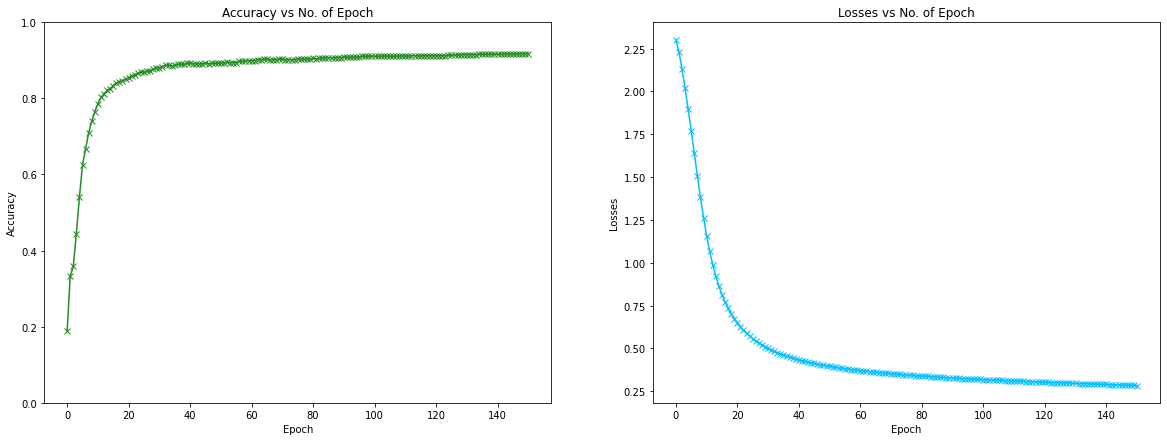

In [ ]:
#Plot history
accuracies = [result['val_acc'] for result in history]
losses = [result['val_loss'] for result in history]
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.plot(accuracies, marker='x', c='forestgreen', ls='-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.title('Accuracy vs No. of Epoch')
plt.subplot(1,2,2)
plt.plot(losses, marker='x', c='deepskyblue', ls='-')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.title('Losses vs No. of Epoch');

##Testing

In [ ]:
#Function to predict label for a single image
def predict_image(img, model):
  xb = img.unsqueeze(0) #add another dimesion at the beginning since it is a single image
  yb = model(xb)
  maxprob, preds = torch.max(yb, dim = 1)
  return preds[0].item()

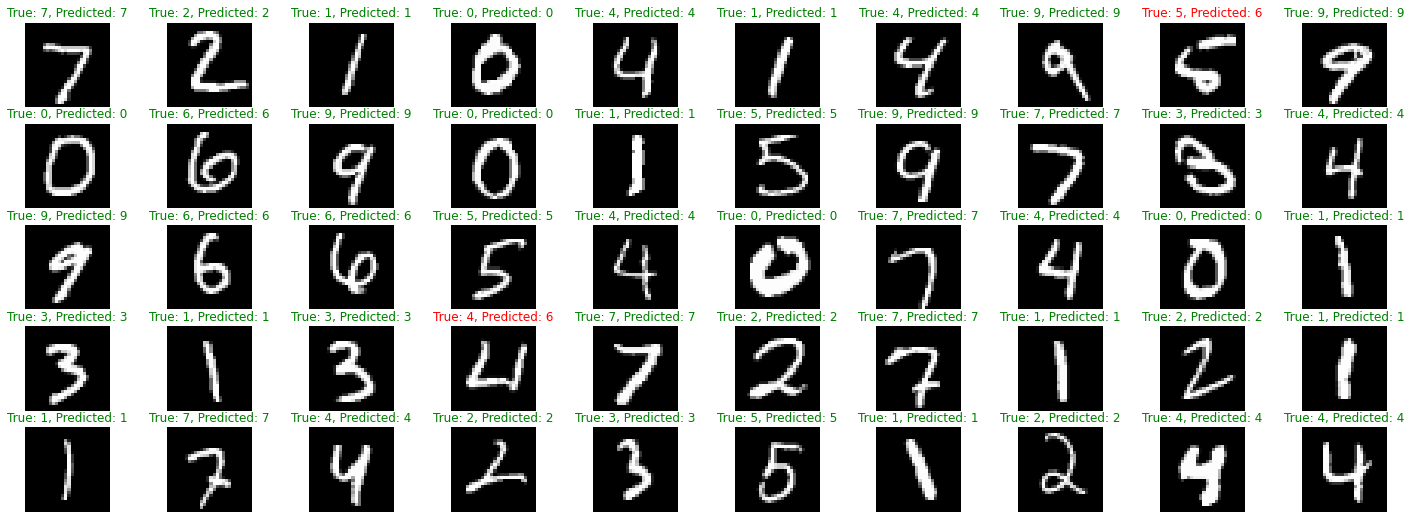

In [ ]:
#Test on multiple images
plt.figure(figsize=(25,9))
# plt.subplots_adjust(hspace=0.4, wspace=0.5)
for i in range(50):
  plt.subplot(5,10,i+1)
  image, label = test_dataset[i]
  #We pass only the 28x28 matrix and exclude the color channel
  plt.imshow(image[0,:,:], cmap='gray')
  predicted_label = predict_image(image,model)
  if predicted_label == label:
    plt.title(f'True: {label}, Predicted: {predicted_label}', color='g')
  else:
    plt.title(f'True: {label}, Predicted: {predicted_label}', color='r')
  plt.axis(False)

In [ ]:
#Overal Loss and Accuracy of the model on test set
test_loader = DataLoader(test_dataset, batch_size = 128)
result = evaluate(model, test_loader)
result

{'val_acc': 0.9207871556282043, 'val_loss': 0.28011196851730347}

##Saving the Model

In [ ]:
#Saving the model
torch.save(model.state_dict(), 'mnist-logistic-model.pth')